In [12]:
# Install dependencies from requirements.txt
%pip install -r requirements.txt

Note: you may need to restart the kernel to use updated packages.


# FTSE/JSE All Share Index Exploratory Data Analysis

This notebook performs a comprehensive exploratory data analysis of the FTSE/JSE All Share Index data, focusing on OHLCV (Open, High, Low, Close, Volume) data and derived technical indicators.

## Research Questions

1. **Market Trends and Patterns**
   - What are the major trends in the FTSE/JSE All Share Index over the analyzed period?
   - Are there any seasonal patterns in price movements?
   - How volatile has the market been during different periods?

2. **Volume Analysis**
   - How does trading volume relate to price movements?
   - Are there patterns in trading volume across different market conditions?
   - Can we identify unusual volume spikes and their relationship with price changes?

3. **Technical Indicators**
   - What insights can we gain from various technical indicators?
   - How do different moving averages correlate with price movements?
   - Can we identify potential overbought/oversold conditions?

4. **Statistical Properties**
   - What is the distribution of returns?
   - Is there evidence of mean reversion or momentum?
   - How stable are the correlations between different technical indicators?

5. **Market Efficiency**
   - Are there any predictable patterns in price movements?
   - How quickly does the market react to significant price changes?
   - Is there evidence of market inefficiencies?

## Import Libraries and Setup Environment

We'll import the necessary libraries for data manipulation, analysis, and visualization:

In [13]:
# Locate and modify the specified file to replace NaN with nan
import os

file_path = r'c:\\Users\\nicol\\AppData\\Local\\Programs\\Python\\Python311\\Lib\\site-packages\\pandas_ta\\momentum\\squeeze_pro.py'

# Check if the file exists
if os.path.exists(file_path):
    with open(file_path, 'r') as file:
        lines = file.readlines()

    # Replace NaN with nan in line 2
    lines[1] = lines[1].replace('NaN', 'nan')

    with open(file_path, 'w') as file:
        file.writelines(lines)
    print("Replaced 'NaN' with 'nan' in line 2 of the file.")
else:
    print("File not found:", file_path)

Replaced 'NaN' with 'nan' in line 2 of the file.


In [14]:
# Data manipulation and analysis
import pandas as pd
import numpy as np
from datetime import datetime

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots

# Technical Analysis
import pandas_ta as ta

# Statistical analysis
from scipy import stats
from statsmodels.tsa.stattools import adfuller
from statsmodels.stats.diagnostic import acorr_ljungbox

# Settings
plt.style.use('seaborn-v0_8-paper')
sns.set_style('whitegrid')
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: '%.4f' % x)

In [15]:
# Configure plotly renderer
import plotly.io as pio
pio.renderers.default = 'iframe'  # Using iframe renderer instead of png

## Data Loading and Cleaning

Let's load the FTSE/JSE All Share data and perform initial cleaning steps:

In [16]:
file_name = 'EURUSD_H1'

# Load the data
df = pd.read_csv(f'raw_data/{file_name}.csv')

# Column names in order: 'Datetime', 'Open', 'High', 'Low', 'Close', 'Volume'
df.columns = ['Date', 'Open', 'High', 'Low', 'Close', 'Volume']

# Convert date column to datetime
df['Date'] = pd.to_datetime(df['Date'])

# Only take the last 3 months data
df = df[df['Date'] >= (df['Date'].max() - pd.DateOffset(months=3))]

In [17]:
# Set Date as index
df.set_index('Date', inplace=True)

# Sort index in ascending order
# Ensure that data is in chronological (ascending) order. 
# This ensures that rolling calculations and lagged features are computed correctly.
df.sort_index(inplace=True)

# Check for missing values
print("Missing values in the dataset:")
print(df.isnull().sum())

# Check for duplicate dates
print("\nNumber of duplicate dates:", df.index.duplicated().sum())

# Remove duplicates if any
df = df[~df.index.duplicated(keep='first')]

# Display basic information about the dataset
print("\nDataset Info:")
print(df.info())

# Display first few rows
print("\nFirst few rows of the dataset:")
print(df.head())

Missing values in the dataset:
Open      0
High      0
Low       0
Close     0
Volume    0
dtype: int64

Number of duplicate dates: 0

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1585 entries, 2025-05-20 09:00:00 to 2025-08-20 09:00:00
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Open    1585 non-null   float64
 1   High    1585 non-null   float64
 2   Low     1585 non-null   float64
 3   Close   1585 non-null   float64
 4   Volume  1585 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 74.3 KB
None

First few rows of the dataset:
                      Open   High    Low  Close  Volume
Date                                                   
2025-05-20 09:00:00 1.1258 1.1267 1.1250 1.1255    6914
2025-05-20 10:00:00 1.1255 1.1258 1.1243 1.1244    7783
2025-05-20 11:00:00 1.1245 1.1252 1.1244 1.1246    6967
2025-05-20 12:00:00 1.1246 1.1247 1.1223 1.1234    5932
2025-05-20 13:00:00 1.1234

## Feature Engineering

#### Explaination of Technical Features from Raw Data:
1. Date: The timestamp indicating the start of the hourly interval
2. Open: The opening price of the asset at the start of the hour
3. High: The highest price reached or traded during the hour
4. Low: The lowest price reached or traded during the hour
5. Close: The closing price of the asset at the end of the hour
6. Volume: The total trading volume during the hour (number of trades or amount of money moved)

Momentum: measures the speed or strenght of proce movements in a specific direction over a given time period. 
Bollinger Bands: measure price volatility and help identify overbought or oversold conditions

#### Engineered Technical Features
These features are common practice in financial data analysis:
1. Hourly_Return: the percentage change in the closing price from one hour to the next
2. Log_Return: The logarithmic return, calculated as the natural log of the ratio of censecutive closing proces for hourly intervals
3.  The greatest of the following for the Hour:
   1.  the current high minus the current low
   2.  the absolute value of the current high minus the previous close
   3.  the absolute value of the current low minus the previous close
4. ATR (Average True Range): A smoothed moving average of the True Range for hourly data, used to measure market volatility
5. Hourly_Volatility: The rolling standard deviation of hourly returns over a specified window, representing price variability
6. SMA_20 (20-hour Simple Moving Average): the average closing price over the last 20 hours
7. SMA_50 (50-hour Simple Moving Average): the average closing price over the last 50 hours
8. EMA_20 (20-hour Exponential Moving Average): a weighted moving average of the closing price over the last 20 hours, giving more weight to recent prices
9. RSI (Relative Strength Index): a momentum oscillator that measure the speed and change of price movements for houly data, typically used to identify overbought or oversold conditions
10. MACD (Moving Average Convergence Divergence): the difference between the 12-hour EMA and the 26-hour EMA, used to identify trends and momentum
11. MACD_Signal: the 9-hour EMA of the MACD, used as a signal line to identify buy or sell opportunities
12. Volume_SMA_20 (2-=hour Volume Simple Moving Average): the average trading volume over the last 20 hours
13. Volume_Ratio: the ration of the current trading volume to the 20-hour Volume SMA, used to identify unusual volume activity
14. Upper_Band: the upper Bollinger Band, claculates as the moving average plus two standard deviations of the price for hourly data.
15. Middle_Band: the middle Bollinger Band, which is the moving average of the price for hourly data.
16. Lower_Band: the lower Bollinger Band, calcualted as the moving average minus two standard deviations fo the price for hourly data.
17. BB_Width (Bollinger Band Width): the relative width of the Bollnger Bands, calculated as the difference between the upper and lower bands divided by the middle band, used to measure volatility for hourly data.
18. Gap: the difference between the opeining price of the current our and the closing price of the previous hour
19. Gap_Pct: the percentage gap, calculated as the gap divided by the previous hhours closing price
20. Hourly_Range: the difference between the high and low prices of the hour
21. Hourly_Range_Pct: the percentage range, calculated as the hourly range divided by the opening price.
22. ADX (Average Directional Index): A trend strenght indicator that measures the strenght of a trend for hourly data, regardless of its direction
23. Trend_Strength: the relative strenght of the trend for hourly intervals, calculated as the absolute difference between the closing price and the 50-Hour SMA, divided by the 50-Hour SMA.

In [18]:
# Create a new dataframe for features
df_features = df.copy()

# 1. Basic Returns
df_features['Hourly_Return'] = df_features['Close'].pct_change()
df_features['Log_Return'] = np.log(df_features['Close']/df_features['Close'].shift(1))

# 2. Volatility Measures
df_features['True_Range'] = df_features.ta.true_range()
df_features['ATR'] = df_features.ta.atr(length=14)
df_features['Hourly_Volatility'] = df_features['Hourly_Return'].rolling(window=21).std()

# 3. Moving Averages
df_features['SMA_20'] = df_features['Close'].rolling(window=20).mean()
df_features['SMA_50'] = df_features['Close'].rolling(window=50).mean()
df_features['EMA_20'] = df_features['Close'].ewm(span=20, adjust=False).mean()

# 4. Momentum Indicators
df_features['RSI'] = df_features.ta.rsi(length=14)
df_features['MACD'] = df_features.ta.macd(fast=12, slow=26, signal=9)['MACD_12_26_9']
df_features['MACD_Signal'] = df_features.ta.macd(fast=12, slow=26, signal=9)['MACDs_12_26_9']

# 5. Volume Indicators
df_features['Volume_SMA_20'] = df_features['Volume'].rolling(window=20).mean()
df_features['Volume_Ratio'] = df_features['Volume'] / df_features['Volume_SMA_20']

# 6. Price Patterns
bbands = df_features.ta.bbands(length=20)
df_features['Upper_Band'] = bbands['BBU_20_2.0']
df_features['Middle_Band'] = bbands['BBM_20_2.0']
df_features['Lower_Band'] = bbands['BBL_20_2.0']
df_features['BB_Width'] = (df_features['Upper_Band'] - df_features['Lower_Band']) / df_features['Middle_Band']

# 7. Gap Analysis
df_features['Gap'] = df_features['Open'] - df_features['Close'].shift(1)
df_features['Gap_Pct'] = df_features['Gap'] / df_features['Close'].shift(1)

# 8. Price Range Features
df_features['Hourly_Range'] = df_features['High'] - df_features['Low']
df_features['Hourly_Range_Pct'] = df_features['Hourly_Range'] / df_features['Open']

# 9. Trend Indicators
df_features['ADX'] = df_features.ta.adx()['ADX_14']
df_features['Trend_Strength'] = abs(df_features['Close'] - df_features['SMA_50']) / df_features['SMA_50']

# Remove any rows with NaN values that resulted from the calculations
df_features.dropna(inplace=True)

# Save the featured dataset
df_features.to_csv(f'raw_data/{file_name}_features.csv')

# Display the first few rows of the featured dataset
print("Shape of the featured dataset:", df_features.shape)
print("\nColumns in the featured dataset:")
print(df_features.columns.tolist())
print("\nFirst few rows of the featured dataset:")
print(df_features.head())

Shape of the featured dataset: (1536, 28)

Columns in the featured dataset:
['Open', 'High', 'Low', 'Close', 'Volume', 'Hourly_Return', 'Log_Return', 'True_Range', 'ATR', 'Hourly_Volatility', 'SMA_20', 'SMA_50', 'EMA_20', 'RSI', 'MACD', 'MACD_Signal', 'Volume_SMA_20', 'Volume_Ratio', 'Upper_Band', 'Middle_Band', 'Lower_Band', 'BB_Width', 'Gap', 'Gap_Pct', 'Hourly_Range', 'Hourly_Range_Pct', 'ADX', 'Trend_Strength']

First few rows of the featured dataset:
                      Open   High    Low  Close  Volume  Hourly_Return  \
Date                                                                     
2025-05-22 10:00:00 1.1294 1.1300 1.1290 1.1292    6253        -0.0002   
2025-05-22 11:00:00 1.1292 1.1313 1.1292 1.1308    8163         0.0015   
2025-05-22 12:00:00 1.1309 1.1315 1.1285 1.1295    8836        -0.0012   
2025-05-22 13:00:00 1.1295 1.1309 1.1281 1.1283   10555        -0.0010   
2025-05-22 14:00:00 1.1283 1.1298 1.1275 1.1277   10462        -0.0005   

                     

## 1. Price Trend Analysis

Let's analyze the basic price trends and patterns in the the data:

In [19]:
# Create an interactive candlestick chart with volume
fig = make_subplots(rows=2, cols=1, shared_xaxes=True, 
                    vertical_spacing=0.03, 
                    row_heights=[0.7, 0.3])

# Add candlestick
fig.add_trace(go.Candlestick(x=df_features.index,
                            open=df_features['Open'],
                            high=df_features['High'],
                            low=df_features['Low'],
                            close=df_features['Close'],
                            name='OHLC'),
              row=1, col=1)

# Add volume bar chart
fig.add_trace(go.Bar(x=df_features.index,
                     y=df_features['Volume'],
                     name='Volume'),
              row=2, col=1)

# Add moving averages
fig.add_trace(go.Scatter(x=df_features.index,
                        y=df_features['SMA_20'],
                        name='20-day SMA',
                        line=dict(color='orange')),
              row=1, col=1)

fig.add_trace(go.Scatter(x=df_features.index,
                        y=df_features['SMA_50'],
                        name='50-day SMA',
                        line=dict(color='blue')),
              row=1, col=1)

# Update layout
fig.update_layout(
    title='EUR-USD Exchange Rate',
    yaxis_title='Price',
    yaxis2_title='Volume',
    xaxis_rangeslider_visible=False,
    height=800
)

fig.show()

# Calculate and display summary statistics
print("\nSummary Statistics:")
print(df_features[['Open', 'High', 'Low', 'Close', 'Volume']].describe())

# Calculate annualized volatility
annual_volatility = df_features['Hourly_Return'].std() * np.sqrt(252)
print(f"\nAnnualized Volatility: {annual_volatility:.2%}")

# Calculate maximum drawdown
cumulative_returns = (1 + df_features['Hourly_Return']).cumprod()
rolling_max = cumulative_returns.expanding().max()
drawdowns = cumulative_returns/rolling_max - 1
max_drawdown = drawdowns.min()
print(f"Maximum Drawdown: {max_drawdown:.2%}")

# Calculate percentage of up days vs down days
up_hours = (df_features['Hourly_Return'] > 0).sum() / len(df_features) * 100
print(f"Percentage of Up Hours: {up_hours:.2f}%")
print(f"Percentage of Down Hours: {100-up_hours:.2f}%")


Summary Statistics:
           Open      High       Low     Close     Volume
count 1536.0000 1536.0000 1536.0000 1536.0000  1536.0000
mean     1.1582    1.1590    1.1575    1.1583  4833.7930
std      0.0140    0.0139    0.0140    0.0140  3489.9215
min      1.1229    1.1250    1.1210    1.1230   301.0000
25%      1.1459    1.1473    1.1452    1.1460  2495.7500
50%      1.1610    1.1618    1.1602    1.1610  4062.0000
75%      1.1695    1.1704    1.1688    1.1695  6313.5000
max      1.1814    1.1830    1.1811    1.1814 35514.0000

Annualized Volatility: 1.56%
Maximum Drawdown: -3.50%
Percentage of Up Hours: 50.85%
Percentage of Down Hours: 49.15%


## 2. Returns and Volatility Analysis

Let's analyze the distribution of returns and patterns in volatility:
1. Returns Distribution: Identify whether returns are centered around zero (no bias toward positive or negative returns). also reveals the shape of the distribution for risk modelling and strategy development.
2. Q-Q (Quantile-Quantile) plot: compares the quantiles of the observed hourly returns to the quantiles of a normal distribution. (if the points lie along the diagonal line, the data is approximately normally distributed) this visually confirms whether the assumption of normality holds
3. 

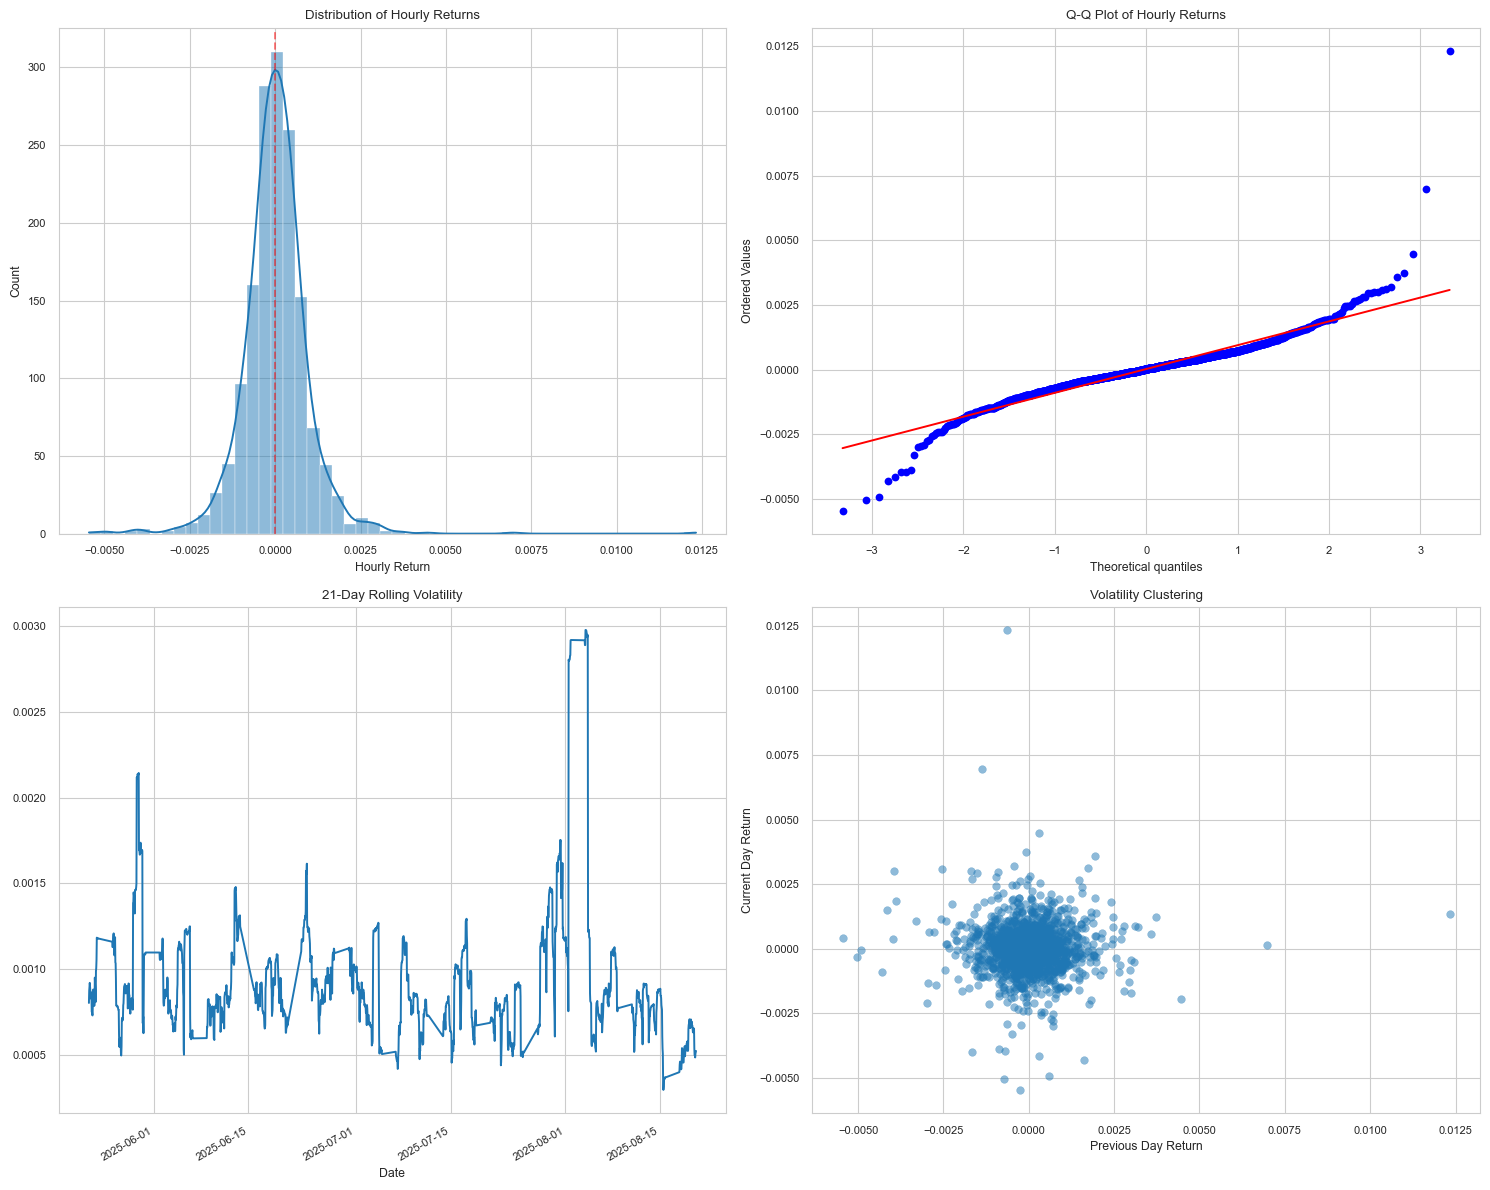

Jarque-Bera test for normality:
Statistic: 26742.18, p-value: 0.0000

Ljung-Box test for autocorrelation:
Statistic: 16.05, p-value: 0.0982

Return Statistics:
count   1536.0000
mean       0.0000
std        0.0010
min       -0.0055
25%       -0.0004
50%        0.0000
75%        0.0005
max        0.0123
Name: Hourly_Return, dtype: float64

Skewness: 1.2076
Excess Kurtosis: 20.3685

Volatility Clustering (AC of absolute returns): 0.1081


In [20]:
# Create subplots for returns analysis
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))

# 1. Returns Distribution
sns.histplot(data=df_features['Hourly_Return'].dropna(), bins=50, kde=True, ax=ax1)
ax1.set_title('Distribution of Hourly Returns')
ax1.set_xlabel('Hourly Return')
ax1.axvline(x=0, color='r', linestyle='--', alpha=0.5)

# 2. Q-Q Plot of Returns
stats.probplot(df_features['Hourly_Return'].dropna(), dist='norm', plot=ax2)
ax2.set_title('Q-Q Plot of Hourly Returns')

# 3. Rolling Volatility
df_features['Hourly_Volatility'].plot(ax=ax3)
ax3.set_title('21-Day Rolling Volatility')
ax3.set_xlabel('Date')

# 4. Volatility Clustering
ax4.scatter(df_features['Hourly_Return'].shift(1), df_features['Hourly_Return'], alpha=0.5)
ax4.set_xlabel('Previous Day Return')
ax4.set_ylabel('Current Day Return')
ax4.set_title('Volatility Clustering')

plt.tight_layout()
plt.show()

# Statistical tests and analysis
# 1. Normality Test (Jarque-Bera)
jb_stat, jb_pval = stats.jarque_bera(df_features['Hourly_Return'].dropna())
print("Jarque-Bera test for normality:")
print(f"Statistic: {jb_stat:.2f}, p-value: {jb_pval:.4f}")

# 2. Autocorrelation Test (Ljung-Box)
lb_test_results = acorr_ljungbox(df_features['Hourly_Return'].dropna(), lags=[10], return_df=True)
print("\nLjung-Box test for autocorrelation:")
print(f"Statistic: {lb_test_results['lb_stat'].iloc[0]:.2f}, p-value: {lb_test_results['lb_pvalue'].iloc[0]:.4f}")

# 3. Summary statistics of returns
print("\nReturn Statistics:")
return_stats = df_features['Hourly_Return'].describe()
print(return_stats)

# 4. Calculate skewness and kurtosis
skew = df_features['Hourly_Return'].skew()
kurt = df_features['Hourly_Return'].kurtosis()
print(f"\nSkewness: {skew:.4f}")
print(f"Excess Kurtosis: {kurt:.4f}")

# 5. Volatility clustering measure (autocorrelation of absolute returns)
vol_cluster = df_features['Hourly_Return'].abs().autocorr()
print(f"\nVolatility Clustering (AC of absolute returns): {vol_cluster:.4f}")

## 3. Technical Indicators Analysis

Let's analyze the relationships between various technical indicators and price movements:

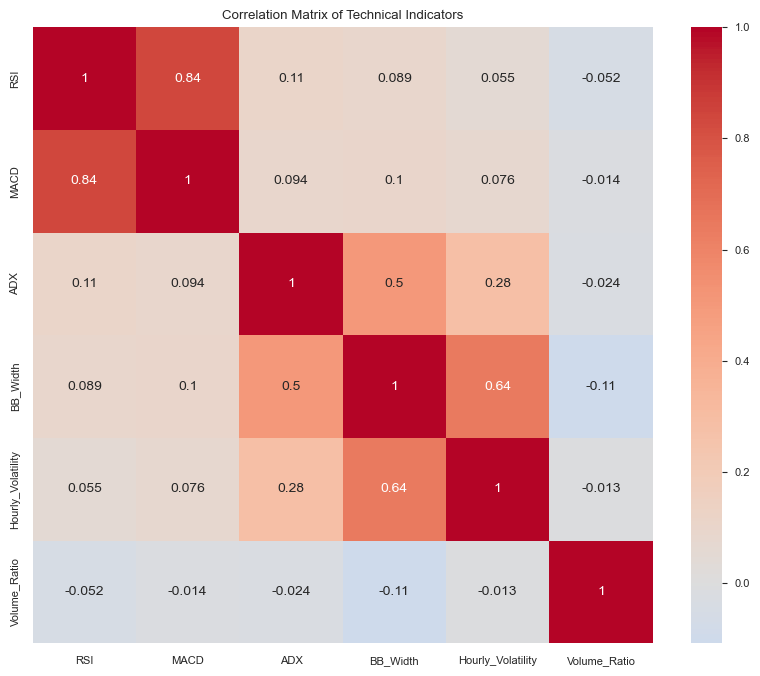

Technical Analysis Summary:
Number of overbought conditions (RSI > 70): 107
Number of oversold conditions (RSI < 30): 64

RSI Signal Analysis:
Average return after buy signal: 0.0081%
Average return after sell signal: -0.0073%

Bollinger Bands Analysis:
BB Width Statistics:
count   1536.0000
mean       0.0062
std        0.0035
min        0.0014
25%        0.0040
50%        0.0054
75%        0.0074
max        0.0255
Name: BB_Width, dtype: float64


In [21]:
# Create correlation matrix for technical indicators
tech_indicators = ['RSI', 'MACD', 'ADX', 'BB_Width', 'Hourly_Volatility', 'Volume_Ratio']
correlation_matrix = df_features[tech_indicators].corr()

# Plot correlation heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Matrix of Technical Indicators')
plt.show()

# Create subplots for technical indicators
fig = make_subplots(rows=3, cols=1, shared_xaxes=True,
                    vertical_spacing=0.05,
                    row_heights=[0.4, 0.3, 0.3])

# 1. Price with Bollinger Bands
fig.add_trace(go.Candlestick(x=df_features.index,
                            open=df_features['Open'],
                            high=df_features['High'],
                            low=df_features['Low'],
                            close=df_features['Close'],
                            name='OHLC'),
              row=1, col=1)

fig.add_trace(go.Scatter(x=df_features.index,
                        y=df_features['Upper_Band'],
                        name='Upper BB',
                        line=dict(color='gray', dash='dash')),
              row=1, col=1)

fig.add_trace(go.Scatter(x=df_features.index,
                        y=df_features['Lower_Band'],
                        name='Lower BB',
                        line=dict(color='gray', dash='dash')),
              row=1, col=1)

# 2. RSI
fig.add_trace(go.Scatter(x=df_features.index,
                        y=df_features['RSI'],
                        name='RSI'),
              row=2, col=1)

fig.add_hline(y=70, line_color='red', line_dash='dash', row=2, col=1)
fig.add_hline(y=30, line_color='green', line_dash='dash', row=2, col=1)

# 3. MACD
fig.add_trace(go.Scatter(x=df_features.index,
                        y=df_features['MACD'],
                        name='MACD'),
              row=3, col=1)

fig.add_trace(go.Scatter(x=df_features.index,
                        y=df_features['MACD_Signal'],
                        name='Signal Line'),
              row=3, col=1)

# Update layout
fig.update_layout(
    title='Technical Analysis Dashboard',
    yaxis_title='Price',
    yaxis2_title='RSI',
    yaxis3_title='MACD',
    height=1000
)

fig.show()

# Analyze overbought/oversold conditions
overbought = (df_features['RSI'] > 70).sum()
oversold = (df_features['RSI'] < 30).sum()

print("Technical Analysis Summary:")
print(f"Number of overbought conditions (RSI > 70): {overbought}")
print(f"Number of oversold conditions (RSI < 30): {oversold}")

# Calculate success rate of RSI signals
df_features['RSI_Signal'] = 0
df_features.loc[df_features['RSI'] < 30, 'RSI_Signal'] = 1  # Buy signal
df_features.loc[df_features['RSI'] > 70, 'RSI_Signal'] = -1  # Sell signal

# Calculate returns following RSI signals
df_features['Next_Return'] = df_features['Hourly_Return'].shift(-1)

buy_returns = df_features[df_features['RSI_Signal'] == 1]['Next_Return']
sell_returns = df_features[df_features['RSI_Signal'] == -1]['Next_Return']

print("\nRSI Signal Analysis:")
print(f"Average return after buy signal: {buy_returns.mean():.4%}")
print(f"Average return after sell signal: {sell_returns.mean():.4%}")

# Analyze BB Width as volatility indicator
print("\nBollinger Bands Analysis:")
print("BB Width Statistics:")
print(df_features['BB_Width'].describe())

## 4. Volume Analysis

Let's analyze trading volume patterns and their relationship with price movements:

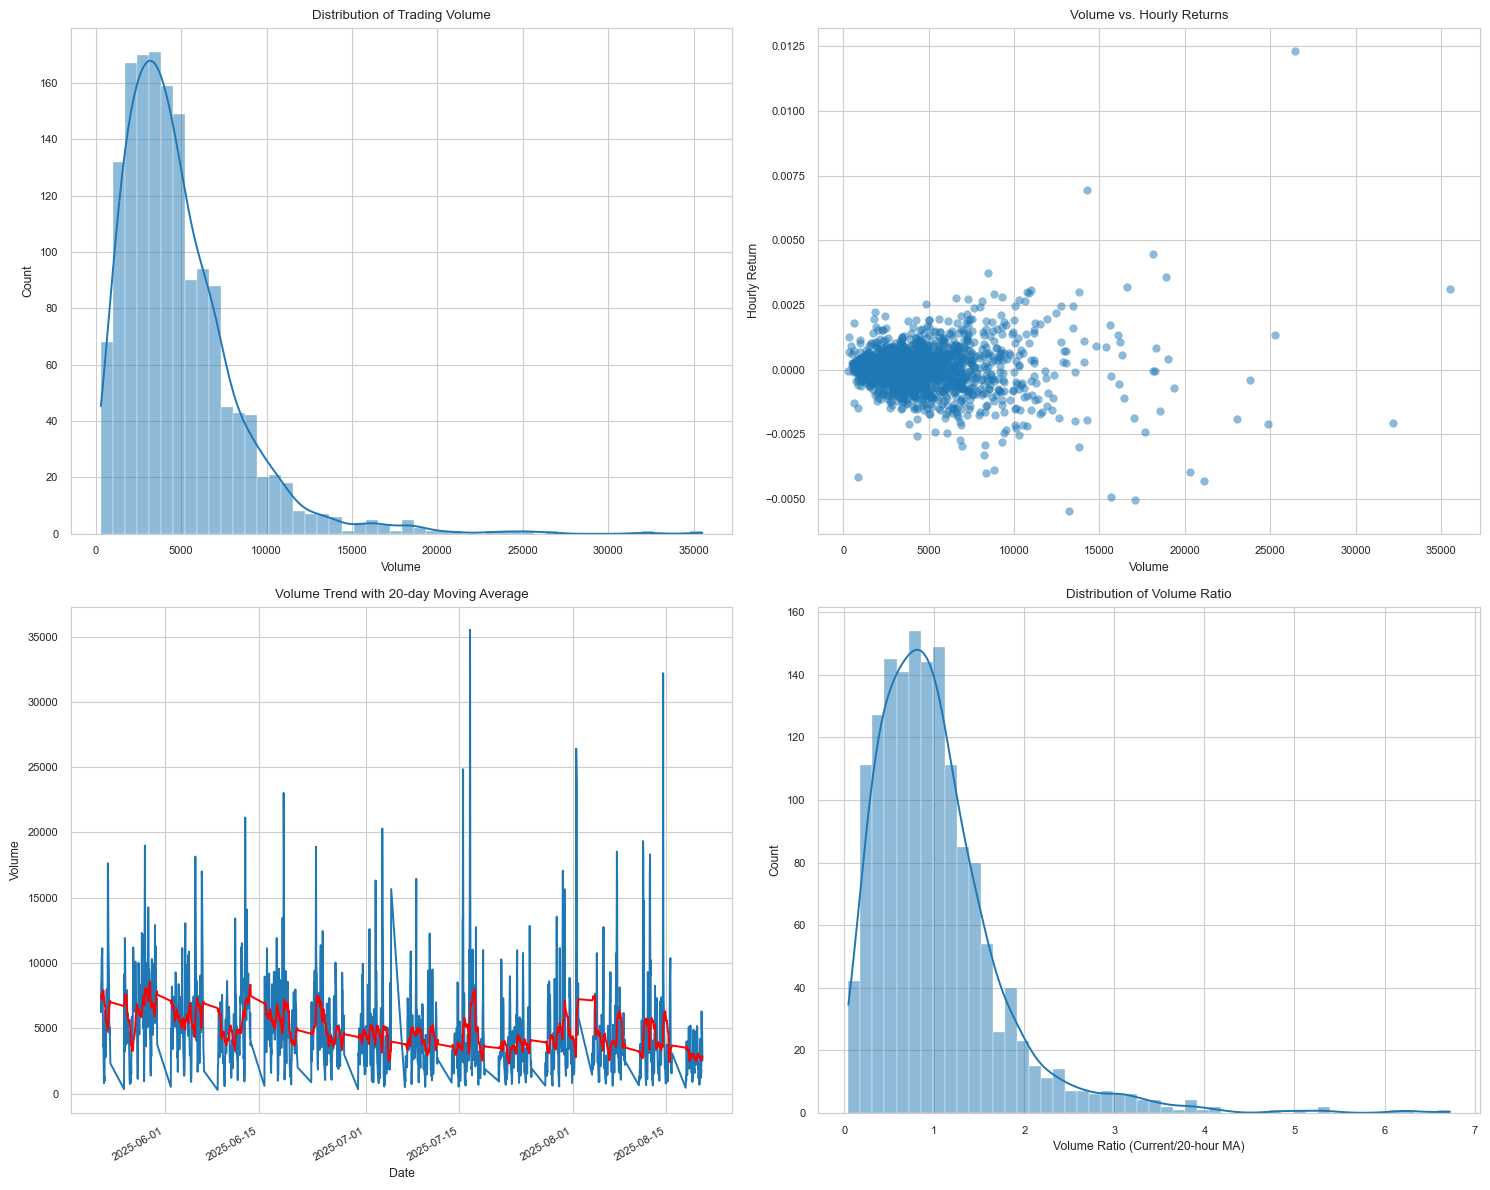

Volume Analysis:

Volume Statistics:
count    1536.0000
mean     4833.7930
std      3489.9215
min       301.0000
25%      2495.7500
50%      4062.0000
75%      6313.5000
max     35514.0000
Name: Volume, dtype: float64

Correlation between Volume and Absolute Returns: 0.4971

Number of High Volume Hours: 58

Average Returns on High Volume Hours vs Normal Hours:
High Volume Hours: 0.0134%
Normal Hours: 0.0016%

Volume 50-hour Trend: -29.73%

High Volume Hours Direction:
Up Hours: 28 (48.3%)
Down Hours: 30 (51.7%)


In [22]:
# Create subplots for volume analysis
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))

# 1. Volume Distribution
sns.histplot(data=df_features['Volume'], bins=50, kde=True, ax=ax1)
ax1.set_title('Distribution of Trading Volume')
ax1.set_xlabel('Volume')

# 2. Volume vs. Hourly Returns Scatter Plot
ax2.scatter(df_features['Volume'], df_features['Hourly_Return'], alpha=0.5)
ax2.set_xlabel('Volume')
ax2.set_ylabel('Hourly Return')
ax2.set_title('Volume vs. Hourly Returns')

# 3. Volume Trend
df_features['Volume'].plot(ax=ax3)
df_features['Volume_SMA_20'].plot(ax=ax3, color='red')
ax3.set_title('Volume Trend with 20-day Moving Average')
ax3.set_xlabel('Date')
ax3.set_ylabel('Volume')

# 4. Volume Ratio Distribution
sns.histplot(data=df_features['Volume_Ratio'], bins=50, kde=True, ax=ax4)
ax4.set_title('Distribution of Volume Ratio')
ax4.set_xlabel('Volume Ratio (Current/20-hour MA)')

plt.tight_layout()
plt.show()

# Calculate volume statistics
print("Volume Analysis:")
print("\nVolume Statistics:")
print(df_features['Volume'].describe())

# Analyze volume-price relationship
volume_return_corr = df_features['Volume'].corr(df_features['Hourly_Return'].abs())
print(f"\nCorrelation between Volume and Absolute Returns: {volume_return_corr:.4f}")

# Identify high volume hours
high_volume_threshold = df_features['Volume'].mean() + 2 * df_features['Volume'].std()
high_volume_hours = df_features[df_features['Volume'] > high_volume_threshold]

print(f"\nNumber of High Volume Hours: {len(high_volume_hours)}")
print("\nAverage Returns on High Volume Hours vs Normal Hours:")
print(f"High Volume Hours: {high_volume_hours['Hourly_Return'].mean():.4%}")
print(f"Normal Hours: {df_features[df_features['Volume'] <= high_volume_threshold]['Hourly_Return'].mean():.4%}")

# Volume trend analysis
volume_trend = df_features['Volume'].rolling(window=50).mean()
current_vol_trend = volume_trend.iloc[-1] / volume_trend.iloc[-50] - 1
print(f"\nVolume 50-hour Trend: {current_vol_trend:.2%}")

# Analyze price changes on high volume hours
high_volume_up = high_volume_hours[high_volume_hours['Hourly_Return'] > 0]
high_volume_down = high_volume_hours[high_volume_hours['Hourly_Return'] < 0]

print("\nHigh Volume Hours Direction:")
print(f"Up Hours: {len(high_volume_up)} ({len(high_volume_up)/len(high_volume_hours)*100:.1f}%)")
print(f"Down Hours: {len(high_volume_down)} ({len(high_volume_down)/len(high_volume_hours)*100:.1f}%)")